In [2]:
!pip install geopandas


Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install gdal

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import osgeo.gdal as gdal
print(gdal.__version__)


3.7.2


In [ ]:
# импорты

In [4]:
import numpy as np
import cv2
from osgeo import gdal
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
# Загрузка данных

In [5]:
import os

In [16]:
# Показать текущий рабочий каталог
current_directory = os.getcwd()
print(f"Current Directory: {current_directory}")

Current Directory: /home/datadisk/jupyter-eddydewrussia


In [37]:
# Путь к папке с данными
data_path = './18/1_20'
layout_path = './18/layouts'

In [23]:
# Получаем список всех файлов в папке 1_20
files = [os.path.join(data_path, file) for file in os.listdir(data_path) if file.endswith('.tif')]

In [24]:
files

['./18/1_20/crop_2_1_0000.tif',
 './18/1_20/crop_2_0_0000.tif',
 './18/1_20/crop_4_3_0000.tif',
 './18/1_20/crop_1_2_0000.tif',
 './18/1_20/crop_3_3_0000.tif',
 './18/1_20/crop_3_0_0000.tif',
 './18/1_20/crop_0_3_0000.tif',
 './18/1_20/crop_4_0_0000.tif',
 './18/1_20/crop_1_3_0000.tif',
 './18/1_20/crop_3_1_0000.tif',
 './18/1_20/crop_1_1_0000.tif',
 './18/1_20/crop_0_2_0000.tif',
 './18/1_20/crop_3_2_0000.tif',
 './18/1_20/crop_4_2_0000.tif',
 './18/1_20/crop_4_1_0000.tif',
 './18/1_20/crop_0_1_0000.tif',
 './18/1_20/crop_2_2_0000.tif',
 './18/1_20/crop_1_0_0000.tif',
 './18/1_20/crop_2_3_0000.tif',
 './18/1_20/crop_0_0_0000.tif']

In [26]:
# Пример загрузки одного из файлов
example_file = files[0]
dataset = gdal.Open(example_file)
band = dataset.GetRasterBand(1) # Получаем первый канал
array = band.ReadAsArray()

/opt/tljh/user/lib/python3.10/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [ ]:
# **Визуализация данных**:
 #  Давайте визуализируем загруженное изображение для понимания его структуры.

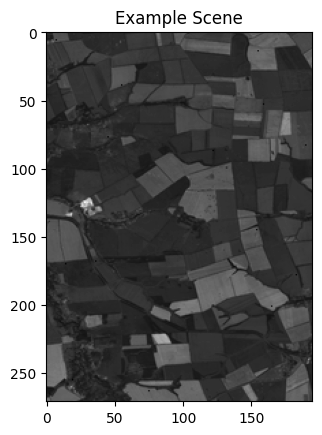

In [27]:
plt.imshow(array, cmap='gray')
plt.title('Example Scene')
plt.show()

In [ ]:
# **Подготовка подложек**:
#   Загрузите и визуализируйте подложки для дальнейшей работы.

In [31]:
layout_files = [os.path.join(layout_path, file) for file in os.listdir(layout_path) if file.endswith('.tif')]

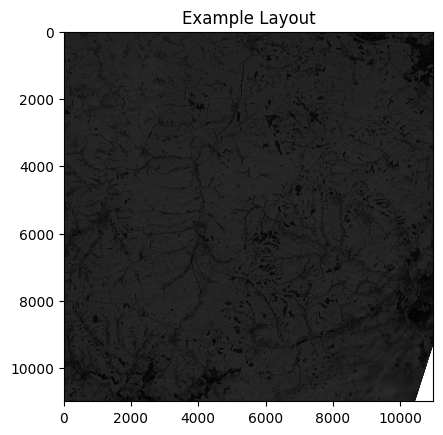

In [32]:
# Загрузка и визуализация первого файла подложки
layout_example = gdal.Open(layout_files[0])
layout_band = layout_example.GetRasterBand(1)
layout_array = layout_band.ReadAsArray()

plt.imshow(layout_array, cmap='gray')
plt.title('Example Layout')
plt.show()

In [33]:
layout_files

['./18/layouts/layout_2022-03-17.tif',
 './18/layouts/layout_2021-10-10.tif',
 './18/layouts/layout_2021-08-16.tif',
 './18/layouts/layout_2021-06-15.tif']

Шаг 6: Предобработка данных
Создание функции для обработки всех файлов:
Загрузим все сцены и подложки.
Преобразуем данные в удобный формат для дальнейшего анализа и обработки.

In [39]:
data_path

'./18/1_20'

In [38]:
def load_images(data_path, layout_path):
    files = [os.path.join(data_path, file) for file in os.listdir(data_path) if file.endswith('.tif')]
    layout_files = [os.path.join(layout_path, file) for file in os.listdir(layout_path) if file.endswith('.tif')]

    scenes = [gdal.Open(file).ReadAsArray() for file in files]
    layouts = [gdal.Open(file).ReadAsArray() for file in layout_files]

    return scenes, layouts


scenes, layouts = load_images(data_path, layout_path)


Шаг 7: Определение геопривязки
Сравнение сцен с подложками:
Применим алгоритм сравнения, который найдет соответствие между сценами и подложками.
Используем метод сопоставления особенностей для нахождения соответствий.

In [40]:
def match_scene_to_layout(scene, layouts):
    best_match = None
    best_score = float('inf')

    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(scene, None)

    for layout in layouts:
        kp2, des2 = orb.detectAndCompute(layout, None)
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)
        matches = sorted(matches, key = lambda x:x.distance)
        
        score = sum([match.distance for match in matches]) / len(matches)
        
        if score < best_score:
            best_score = score
            best_match = layout

    return best_match, best_score

# Пример для одной сцены
best_layout, score = match_scene_to_layout(scenes[0], layouts)


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 195


Ошибка, которую вы видите, указывает на то, что OpenCV не может обработать изображение, вероятно, из-за некорректного количества каналов. Давайте проверим формат изображений и убедимся, что они имеют правильное количество каналов (обычно 1 для черно-белых изображений и 3 для цветных).

Шаг 7: Исправление ошибки с количеством каналов
Преобразование изображений в одноцветный формат:
Убедимся, что изображения сцены и подложки имеют правильный формат (один канал).

In [42]:
def preprocess_image(image):
    if len(image.shape) == 3:
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

def match_scene_to_layout(scene, layouts):
    best_match = None
    best_score = float('inf')

    orb = cv2.ORB_create()
    scene_gray = preprocess_image(scene)
    kp1, des1 = orb.detectAndCompute(scene_gray, None)

    for layout in layouts:
        layout_gray = preprocess_image(layout)
        kp2, des2 = orb.detectAndCompute(layout_gray, None)
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)
        
        score = sum([match.distance for match in matches]) / len(matches)
        
        if score < best_score:
            best_score = score
            best_match = layout

    return best_match, best_score

# Пример для одной сцены
best_layout, score = match_scene_to_layout(scenes[0], layouts)


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 195
